# AWS IP Insights Algorithm - Add Noise to Data

Here there! <br>
Welcome to this notebook and repository. This is an code example for the [blog](https://data-centric-mind.medium.com/ip-insights-model-add-some-11d993c0d860) series. Hope you enjoy this notebook with your coffee (or tea)!

-------

## Introduction

In the previous [blogs](https://data-centric-mind.medium.com/ip-insights-model-de-simplify-part-i-6e8067227ceb), we explained how the IP Insights model works and how the data were simulated. However,  when we use the training data to get the entity embeddings, we assume all the records and logins in the training are valid and normal. This is a very strong assumption as there might be incidents or breaches you weren’t aware of. For example, it is very common that the security incidents were not properly reported or collected.

You may not have a super clean dataset. That’s the reality. However, the anomaly points volume should be very very low. We can somehow ignore their impacts, or … can we ? Let’s still run a simulation to verify the impact of these anomalies we ignored.


In this notebook, we want to test when we have noise in the data that we couldn't remove, will this model still work?



## Tips for AWS free tier users:
    
1. Check the doc [here](https://aws.amazon.com/free/?all-free-tier.sort-by=item.additionalFields.SortRank&all-free-tier.sort-order=asc&awsf.Free%20Tier%20Types=*all&awsf.Free%20Tier%20Categories=*all)
to make sure you only used the services (especially instance) covered by AWS free tier
2. Don't repeat the data generation process, as S3 charged by the number of read/write.
3. You can start with a much smaller set of users by set NUM_USERS = 100


________________


## Contents 


1. [Setup](#Setup)
2. [Modification_of_Data](#Modification_of_Data)
3. [Training](#Training)
4. [SaveModel](#SaveModel)


 


## Setup
-------

Setup AWS S3 Connections, accessing data in S3

In [26]:
## read config file

import configparser
config = configparser.ConfigParser()
config.sections()

config.read('conf.ini')

['conf.ini']

In [30]:
# config file
if 'prefix' in config['ipinsights']:
    prefix = config['ipinsights']['prefix']
else:
    sys.exit("please provide prefix for you AWS S3 in the INI file")

In [4]:
import pandas as pd
import boto3
import io
import botocore
import os
import sagemaker

# setting for S3 connection 

bucket = sagemaker.Session().default_bucket()
execution_role = sagemaker.get_execution_role()
region = boto3.Session().region_name
prefix = prefix
s3_client = boto3.client('s3')

In [23]:
# loading training data from S3 bucket 
train_data_file = "train.csv"
file_key = os.path.join(prefix, "train", train_data_file)
obj = s3_client.get_object(Bucket=bucket, Key=file_key)

train_df = pd.read_csv(io.BytesIO(obj['Body'].read()), names = ['user', 'ip_address'])
train_df.head()

,user,ip_address
0,user_7662,90.166.249.22
1,user_2745,69.67.71.195
2,user_1628,196.16.247.163
3,user_5766,193.58.243.4
4,user_1370,213.194.79.91


In [24]:
train_df.shape

(2107898, 2)

## Modification_of_Data 
-------

### Generate Noise

There are 10000 users and around 2 million records in the training data we generated. Let's assume there are 0.5% users (50) has 1% anomaly events each (20 records). The anomaly events were generated by randomly sampling IP addresses to the target 0.5% users. Therefore, we added around 0.05% noisy to the training data which should be a fair estimate.


In [38]:
import numpy as np
from generate_data import draw_ip

def add_noise(train_df, user_perc, noise_per_account):
    """
    This is a modified function compared to the original one.
    Creates a test case from provided train and test data frames.

    This generates test case for accounts that are both in training and testing data sets.

    :param train_df: (panda.DataFrame with columns ['user', 'ip_address']) training DataFrame
    :param user_perc: (float, [0,1]) percentage of users have noisy IPs
    :param num_samples: (int) number of test samples to use
    :param noise_pert_account: (int) number of random logins to added to each account
    :return: DataFrame with both good and bad traffic, with labels
    """
    # Get all possible accounts. The IP Insights model can only make predictions on users it has seen in training
    # Therefore, filter the test dataset for unseen accounts, as their results will not mean anything.
    valid_accounts = set(train_df["user"])

    # Generate malicious traffic
    num_bad_account = int(len(valid_accounts) * user_perc  )
    bad_traffic_accounts = np.random.choice(
        list(valid_accounts), size=num_bad_account, replace=False
    )

    bad_traffic_ips = [draw_ip() for i in range(num_bad_account * noise_per_account)]
    bad_traffic = pd.DataFrame({"user": list(bad_traffic_accounts) * noise_per_account, "ip_address": bad_traffic_ips})
    bad_traffic["label"] = 1

    # All traffic labels are: 0 for good traffic; 1 for bad traffic.

    return bad_traffic

In [39]:
noise_df = add_noise(train_df, user_perc = 0.005, noise_per_account = 20)
noise_df.head()

,user,ip_address,label
0,user_5989,200.94.199.45,1
1,user_2332,209.26.23.115,1
2,user_567,126.43.99.6,1
3,user_8345,181.102.151.44,1
4,user_5560,165.98.22.188,1


In [40]:
noise_df.shape

(1000, 3)

## Merge the noise and the training data and upload to S3

In [ ]:
train_new = pd.concat([noise_df[['user', 'ip_address']], train_df], ignore_index = True)

In [68]:
train_new.shape

(2108898, 2)

In [69]:
train_new_data = train_new.to_csv(index=False, header=False, columns=["user", "ip_address"])

In [ ]:
## uploading the new data to S3

new_train = "new_train.csv"
key = os.path.join(prefix, "new_train", new_train)
boto3.resource("s3").Bucket(bucket).Object(key).put(Body=train_new_data)

# Training
-------

The steps here are quite similar to the original model training and tuning. The only difference is instead of tuning the vector_dim, we stick with the 128 dim and tune the learning_rate and num_ip_encoder_layers instead. 

In [49]:
from sagemaker.amazon.amazon_estimator import get_image_uri

image = get_image_uri(boto3.Session().region_name, "ipinsights")
# image_uri

The method get_image_uri has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: 1.


In [50]:
# Set up the estimator with training job configuration
ip_insights = sagemaker.estimator.Estimator(
    image,
    execution_role,
    instance_count=1,
    instance_type = 'ml.m5.xlarge',
    output_path=f"s3://{bucket}/{prefix}/output",
    sagemaker_session=sagemaker.Session(),
)

# Configure algorithm-specific hyperparameters
ip_insights.set_hyperparameters(
    num_entity_vectors="20000",
    random_negative_sampling_rate="5",
    vector_dim="128",
    mini_batch_size="1000",
    epochs="5",
    learning_rate="0.01",
)


In [62]:
from sagemaker.tuner import HyperparameterTuner, IntegerParameter, ContinuousParameter

# Configure HyperparameterTuner
ip_insights_tuner = HyperparameterTuner(
    estimator=ip_insights,  # previously-configured Estimator object
    objective_metric_name="validation:discriminator_auc",
    hyperparameter_ranges={"learning_rate": ContinuousParameter(0.001, 0.01), 'num_ip_encoder_layers': IntegerParameter(1, 3)},
    max_jobs=4,
    max_parallel_jobs=2,
)


In [74]:
# config input data
validation_data_file = "valid.csv"
key = os.path.join(prefix, "validation", validation_data_file)
s3_valid_data = f"s3://{bucket}/{key}"

new_train = "new_train.csv"
train_key = os.path.join(prefix, "new_train", new_train)
s3_new_train_data = f"s3://{bucket}/{train_key}"

input_data = {"train": s3_new_train_data, "validation": s3_valid_data}


In [ ]:
# Start hyperparameter tuning job
ip_insights_tuner.fit(input_data, include_cls_metadata=False)

# Wait for all the jobs to finish
ip_insights_tuner.wait()

# Visualize training job results
ip_insights_tuner.analytics().dataframe()


...............................................................................................................................................

## A quick summary of the auto-tuning models and best performance settings

In [82]:
ip_insights_tuner.analytics().dataframe()

,learning_rate,num_ip_encoder_layers,TrainingJobName,TrainingJobStatus,FinalObjectiveValue,TrainingStartTime,TrainingEndTime,TrainingElapsedTimeSeconds
0,0.004267,3.0,ipinsights-220102-0319-004-1b1d3d41,Completed,0.991415,2022-01-02 03:36:22+00:00,2022-01-02 04:08:03+00:00,1901.0
1,0.004076,3.0,ipinsights-220102-0319-003-80770fd8,Completed,0.991488,2022-01-02 03:36:20+00:00,2022-01-02 04:05:30+00:00,1750.0
2,0.005583,1.0,ipinsights-220102-0319-002-948f80ac,Completed,0.990986,2022-01-02 03:21:46+00:00,2022-01-02 03:33:42+00:00,716.0
3,0.005834,1.0,ipinsights-220102-0319-001-96fa8b31,Completed,0.990976,2022-01-02 03:21:31+00:00,2022-01-02 03:34:02+00:00,751.0


It looks like the second model has the best performance with a learning_rate = 0.004 and a encoder_layers = 3
<br>
The model will be saved the to S3 and you can load and serve it anytime you want to run inference. 

Below is how it looks on AWS Sagemaker, you can see there is one active hyperparameter tuning jobs running. 


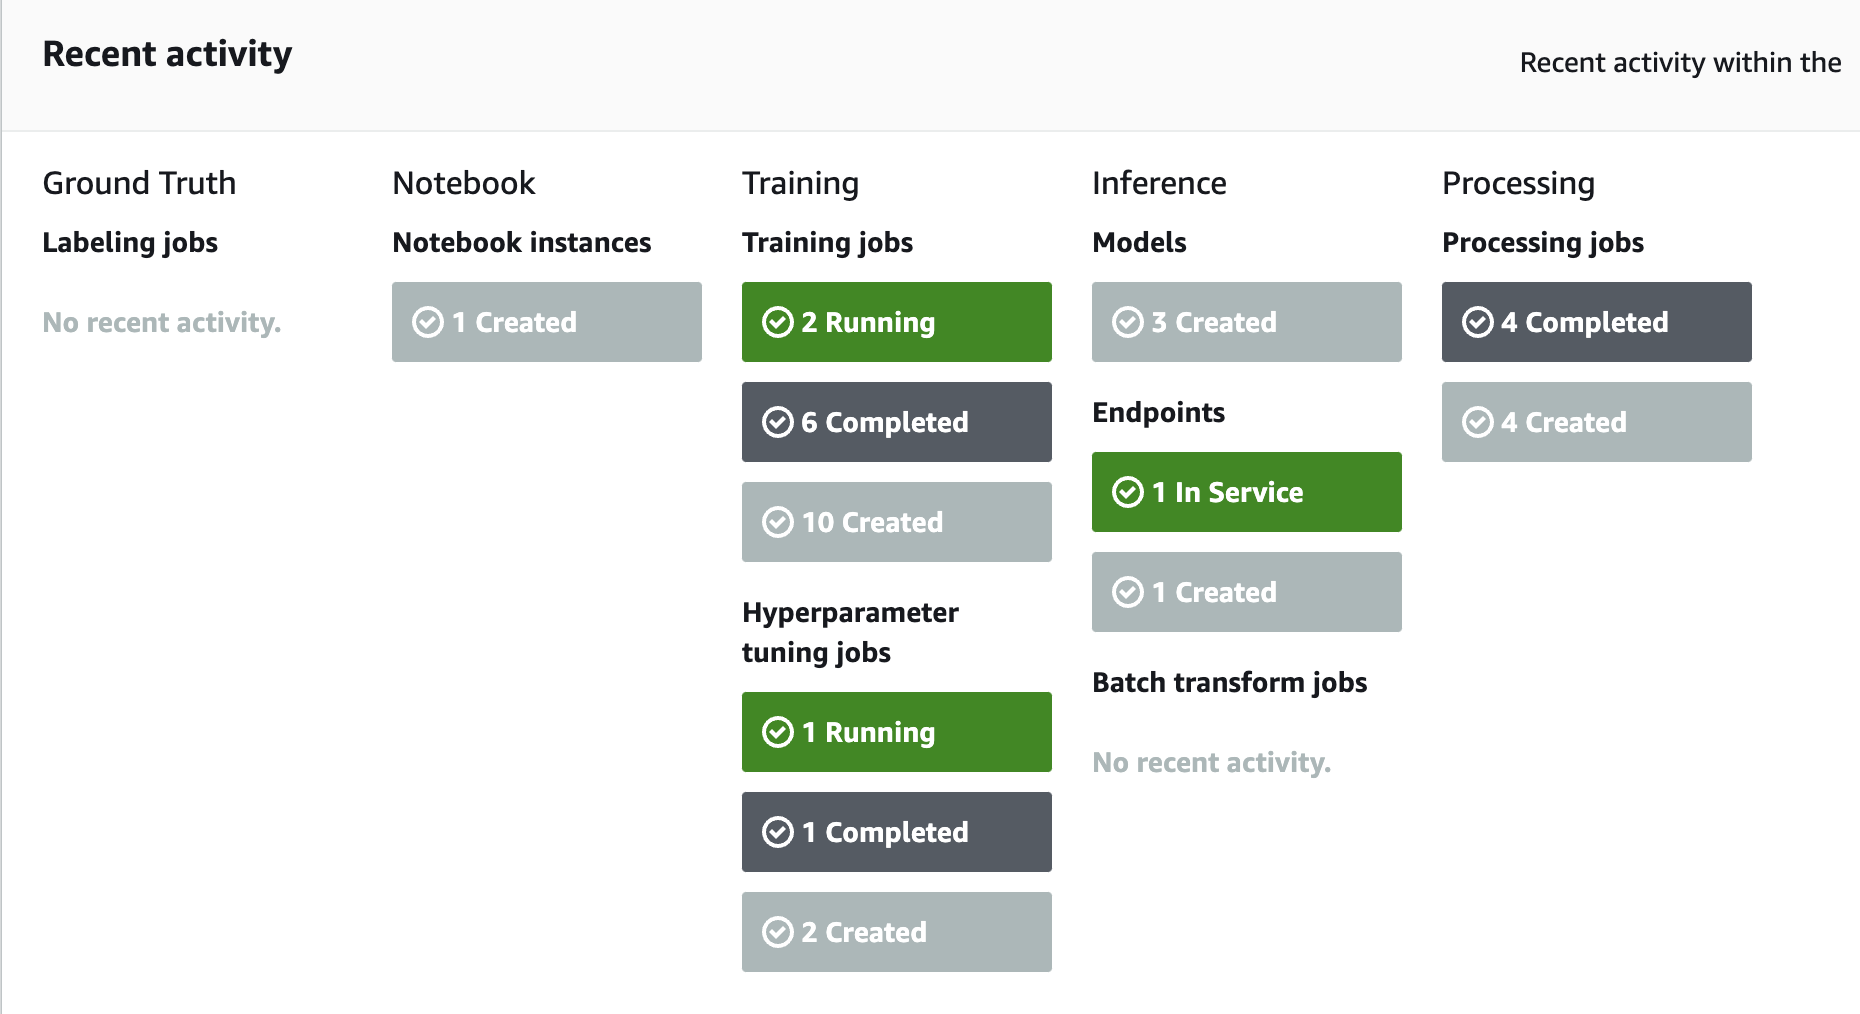

In [4]:
# import image module
from IPython.display import Image
# get the image
Image("aws_hyper_tuning.jpeg", width=3000, height=600)


### Stop and Delete the Endpoint
If you are done with this model, then we should delete the endpoint before we close the notebook. Or else you will continue to pay for the endpoint while it is running. 

To do so execute the cell below. Alternately, you can navigate to the "Endpoints" tab in the SageMaker console, select the endpoint with the name stored in the variable endpoint_name, and select "Delete" from the "Actions" dropdown menu.

In [43]:
ip_insights_tuner.delete_endpoint()
sagemaker.Session().delete_endpoint(predictor.endpoint)

The function delete_endpoint is a no-op in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
The endpoint attribute has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
